In [ ]:
#!pip install brotli
#!pip install datasets
#!pip install Keras-Preprocessing
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

In [ ]:
import gzip
import lzma
import brotli
import bz2
import datasets
import numpy as np
from tqdm import tqdm
import pandas as pd
import concurrent.futures
from sklearn.model_selection import train_test_split
import spacy
from nltk import word_tokenize
import nltk
import re
import string
from nltk.stem.wordnet import WordNetLemmatizer
from keras import utils
from keras.layers import LSTM, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential

### Carregamento dos dados e criação de subsets

In [ ]:
# pegar uma porcentagem do dataset de tal modo que as classes estejam balanceadas
def get_balanced_dataset(dataset, percentage):
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    dataset = pd.DataFrame(dataset)
    dataset = dataset[["Noticia", "Categoria", "label"]]
    dataset = dataset.groupby("Categoria").apply(lambda x: x.sample(frac=percentage)).reset_index(drop=True)
    return dataset

def selected_categories(row):
    return row["Categoria"] in ["Política", "Internacional", "Saúde", "Ciência e Tecnologia", "Economia"]

In [ ]:
dataset = datasets.load_dataset("recogna-nlp/recognasumm")

In [ ]:
len(set(dataset['train']['Categoria']))

24

In [ ]:
dataset = dataset.filter(selected_categories)

In [ ]:
Categories = ["Política", "Internacional", "Saúde", "Ciência e Tecnologia", "Economia"]
Categories

['Política', 'Internacional', 'Saúde', 'Ciência e Tecnologia', 'Economia']

In [ ]:
def catgeory2label(row):
    row["label"] = Categories.index(row["Categoria"])
    return row

In [ ]:
dataset = dataset.map(catgeory2label)

<Axes: title={'center': 'Distribuição das categorias'}, xlabel='Categoria'>

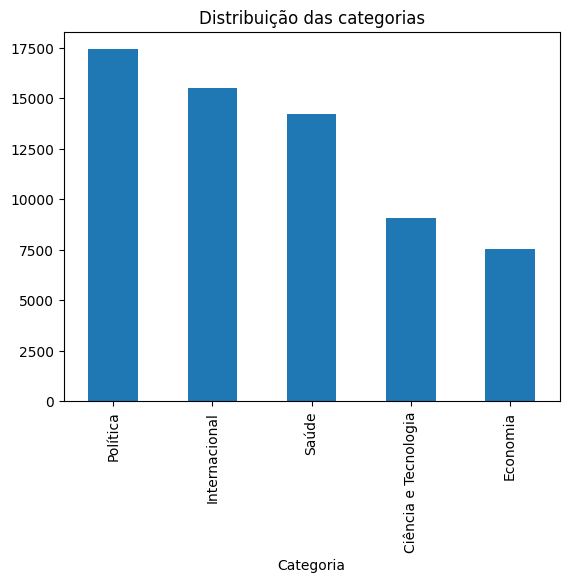

In [ ]:
pd.DataFrame(dataset['train'])['Categoria'].value_counts().plot(kind='bar', title='Distribuição das categorias')

#### Aqui o treino ficou com um tamanho de 4783 e o teste e validação 530

In [ ]:
perc_train = 0.075
perc = 0.025

train_df = get_balanced_dataset(dataset["train"], perc_train)
teste_df = get_balanced_dataset(dataset["test"], perc)
valid_df = get_balanced_dataset(dataset["validation"], perc)

<Axes: title={'center': 'Distribuição das categorias - Treino RecognaSumm'}, xlabel='Categoria'>

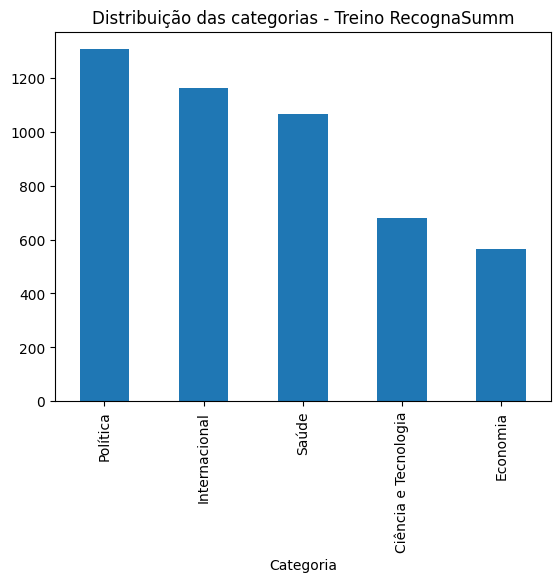

In [ ]:
pd.DataFrame(train_df)['Categoria'].value_counts().plot(kind='bar', title='Distribuição das categorias - Treino RecognaSumm')

In [ ]:
train_df['Categoria'].value_counts()

Categoria
Política                1307
Internacional           1163
Saúde                   1068
Ciência e Tecnologia     679
Economia                 566
Name: count, dtype: int64

### PIPELINE do modelo em análise

In [ ]:
training_set = list(zip(train_df["Noticia"], train_df["Categoria"], train_df["label"]))
test_set = list(zip(teste_df["Noticia"], teste_df["Categoria"], teste_df["label"]))
valid_set = list(zip(valid_df["Noticia"], valid_df["Categoria"], valid_df["label"]))

<Axes: xlabel='Categoria'>

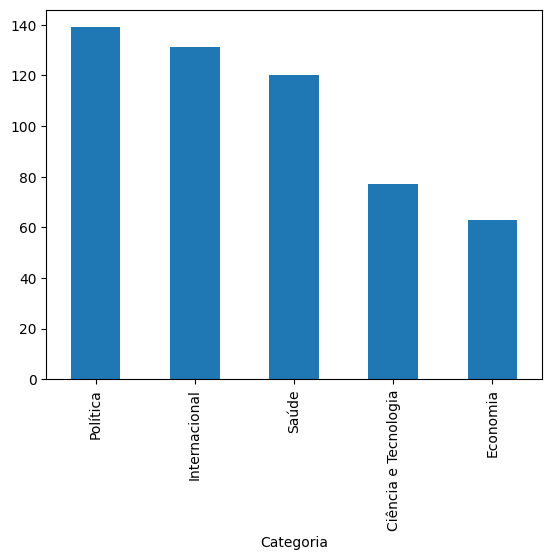

In [ ]:
pd.DataFrame(teste_df)['Categoria'].value_counts().plot(kind='bar')

## Avaliação

Para fazer a avaliação da classificação do modelo em análise, basta que duas listas existam: y_test e y_hat.   

y_test = [0,0,1,2,3,4]   
y_hat =  [0,1,1,1,3,4]   
                 
Categories = ["Política", "Internacional", "Saúde", "Ciência e Tecnologia", "Economia"] - >  [0             1             2              3                  4 ]   

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [ ]:
y_test = [y for (_, _, y) in test_set]
y_train = [y for (_, _, y) in training_set]
y_valid = [y for (_, _, y) in valid_set]

In [ ]:
def preprocessamento(texto):
    # 1. Remover caracteres especiais e números
    texto = re.sub(r'\d+', '', texto)
    texto = texto.lower()  # Converter texto para minúsculas
    texto = texto.strip()  # Remover espaços em branco extras

    # 2. Remover pontuações
    texto = texto.translate(str.maketrans('', '', string.punctuation))

    # 3. Tokenização
    tokens = word_tokenize(texto)

    # 4. Remover stopwords
    stop_words = set(nltk.corpus.stopwords.words('portuguese'))  # Para o idioma português
    tokens = [word for word in tokens if word not in stop_words]

    # 5. Lematiza
    wordnet_lemmatizer = WordNetLemmatizer()
    tokens = [wordnet_lemmatizer.lemmatize(word) for word in tokens]

    # 6. Juntar tokens de volta em texto
    processado = ' '.join(tokens)

    return processado

In [ ]:
train_df = train_df['Noticia']
teste_df = teste_df['Noticia']
valid_df = valid_df['Noticia']

In [ ]:
y_teste = utils.to_categorical(y_test)
y_train = utils.to_categorical(y_train)
y_valid = utils.to_categorical(y_valid)

In [ ]:
#Aplica a função em todos os dados:
data_train = [preprocessamento(i) for i in train_df]
data_test = [preprocessamento(i) for i in teste_df]
data_valid = [preprocessamento(i) for i in valid_df]

In [ ]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_df)

X_train = word_tokenizer.texts_to_sequences(data_train)
X_test = word_tokenizer.texts_to_sequences(data_test)
X_valid = word_tokenizer.texts_to_sequences(data_valid)

In [ ]:
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

71790

In [ ]:
maxlen = 100

train_df = pad_sequences(X_train, padding='post', maxlen=maxlen)
teste_df = pad_sequences(X_test, padding='post', maxlen=maxlen)
valid_df = pad_sequences(X_valid, padding='post', maxlen=maxlen)

In [ ]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(100))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(5, activation='softmax'))

In [ ]:
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          7179000   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 7296893 (27.84 MB)
Trainable params: 117893 (460.52 KB)
Non-trainable params: 7179000 (27.39 MB)
_________________________________________________________________
None


In [ ]:
lstm_model_history = lstm_model.fit(train_df, y_train, batch_size=128, epochs=200, verbose=1,
                                    validation_data=(valid_df, y_valid))

Epoch 1/6
38/38 [==============================] - 14s 294ms/step - loss: 1.5635 - acc: 0.2852
Epoch 2/6
38/38 [==============================] - 10s 263ms/step - loss: 1.5244 - acc: 0.3082
Epoch 3/6
38/38 [==============================] - 11s 294ms/step - loss: 1.5035 - acc: 0.3669
Epoch 4/6
38/38 [==============================] - 12s 306ms/step - loss: 1.4359 - acc: 0.3822
Epoch 5/6
38/38 [==============================] - 12s 326ms/step - loss: 1.4236 - acc: 0.3740
Epoch 6/6
38/38 [==============================] - 12s 318ms/step - loss: 1.4024 - acc: 0.3995


In [ ]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

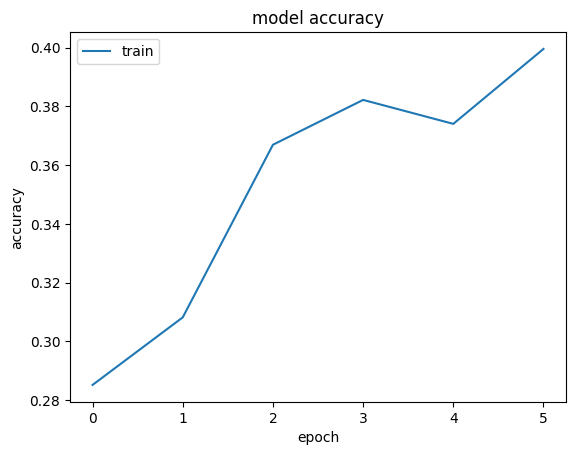

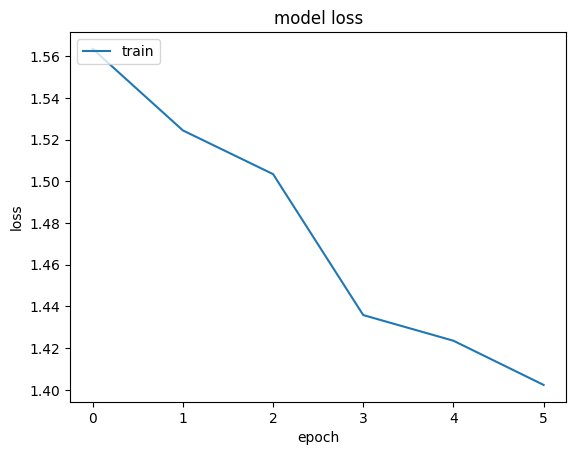

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()